In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv('dataset/in_and_out.csv', index_col=0, encoding='cp949')
data

,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,07시-08시 하차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
사용월,,,,,,,,,,,,,,,,,,,,,
202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,13000,...,9939,938,3210,3,321,0,0,0,0,20250503
202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,11943,...,4897,120,1996,3,267,0,0,0,0,20250503
202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,135373,...,29252,5212,8018,10,262,0,0,0,0,20250503
202504,1호선,시청,124,5,2267,5900,3888,28761,7841,84305,...,3763,606,1015,0,15,0,0,0,0,20250503
202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,27668,...,9416,455,3039,0,0,1,2,0,0,20250503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202305,중앙선,원덕,95,0,394,6,740,182,885,546,...,328,3,80,0,0,0,0,0,0,20230603
202305,중앙선,중랑,153,5,6886,593,10126,2329,24074,3322,...,5311,34,486,0,0,0,0,0,0,20230603
202305,중앙선,지평,0,0,0,0,4,2,384,294,...,0,0,0,0,0,0,0,0,0,20230603


In [3]:
# 승차/하차 컬럼 추출
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 전체 승차/하차 인원 합계 및 평균
data['total_board'] = data[boarding_cols].sum(axis=1)
data['total_alight'] = data[alighting_cols].sum(axis=1)
data['mean_board'] = data[boarding_cols].mean(axis=1)
data['mean_alight'] = data[alighting_cols].mean(axis=1)
data['peak_board_time'] = data[boarding_cols].idxmax(axis=1)


In [4]:
# 월별 시간대별 승차인원 합계
monthly_boarding_sum = data.groupby('사용월')[boarding_cols].sum()

# 월별, 역별 승차인원 합계
monthly_station_boarding_sum = data.groupby(['사용월', '지하철역'])[boarding_cols].sum()

# 월별, 노선별 승차인원 합계
monthly_line_boarding_sum = data.groupby(['사용월', '호선명'])[boarding_cols].sum()

# 월별 피크승차시간대
def get_peak_time(group):
    sum_boarding = group[boarding_cols].sum()
    return sum_boarding.idxmax()

monthly_peak_time = data.groupby('사용월').apply(get_peak_time)


print("월별 시간대별 승차인원 합계:", monthly_boarding_sum.head())
print("월별, 역별 승차인원 합계:", monthly_station_boarding_sum.head())
print("월별, 노선별 승차인원 합계:", monthly_line_boarding_sum.head())
print("월별 피크승차시간대:", monthly_peak_time.head())


월별 시간대별 승차인원 합계:         04시-05시 승차인원  05시-06시 승차인원  06시-07시 승차인원  07시-08시 승차인원  08시-09시 승차인원  \
사용월                                                                            
202305        146165       3356902       6911490      16720077      18915764   
202306        151808       3348040       6852651      16500204      18497501   
202307        150063       3288599       6767405      16141259      18052137   
202308        151882       3246581       6735882      15979882      17776280   
202309        154195       3142257       6495267      15739413      17587220   

        09시-10시 승차인원  10시-11시 승차인원  11시-12시 승차인원  12시-13시 승차인원  13시-14시 승차인원  \
사용월                                                                            
202305      12286666       9424112       9370528      10251665      10381059   
202306      11727340       8996698       8983075       9716302       9887393   
202307      11368530       8771157       8825187       9624621       9730603   
202308      11160062  

In [5]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 시간대별 승차/하차 컬럼
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 월별 그룹화
grouped = data.groupby('사용월')
cca_results = []

for month, group in grouped:
    X = group[boarding_cols].fillna(0)
    Y = group[alighting_cols].fillna(0)
    X_sc = StandardScaler().fit_transform(X)
    Y_sc = StandardScaler().fit_transform(Y)
    cca = CCA(n_components=1)
    cca.fit(X_sc, Y_sc)
    X_c, Y_c = cca.transform(X_sc, Y_sc)
    corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    cca_results.append((month, corr))

import pandas as pd
cca_df = pd.DataFrame(cca_results, columns=['사용월', 'CCA 상관계수'])
print(cca_df)


c:\Users\kkh02\llll\.venv\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


       사용월  CCA 상관계수
0   202305  0.995565
1   202306  0.995626
2   202307  0.995956
3   202308  0.996061
4   202309  0.995509
5   202310  0.995424
6   202311  0.995737
7   202312  0.995937
8   202401  0.995973
9   202402  0.995868
10  202403  0.995590
11  202404  0.999658
12  202405  0.995584
13  202406  0.995591
14  202407  0.995928
15  202408  0.995834
16  202409  0.996069
17  202410  0.995668
18  202411  0.995637
19  202412  0.995933
20  202501  0.995751
21  202502  0.995998
22  202503  0.995544
23  202504  0.995841


CCA 상관계수란?

시간대별 승차 인원과 시간대별 하차 인원 집단의 선형 결합 간 상관관계를 의미합니다.

1에 가까울수록 두 집단의 패턴이 매우 유사함을 뜻합니다.

결과의 의미

**매우 높은 상관계수(0.995 이상)**는 월별로 시간대별 승차 패턴과 하차 패턴이 거의 동일하게 움직인다는 뜻입니다.

즉, 특정 시간대에 승차 인원이 많으면 같은 시간대에 하차 인원도 많고, 그 반대도 마찬가지라는 구조가 거의 모든 월에 일관적으로 나타납니다.

이는 지하철 이용 패턴이 시간대별로 매우 규칙적이고, 승차와 하차의 흐름이 서로 밀접하게 연결되어 있음을 보여줍니다.

실제적 해석

출근 시간대, 퇴근 시간대 등 주요 혼잡 시간대에는 승차와 하차가 동시에 집중되는 경향이 강하다는 것을 시사합니다.

역별, 노선별로는 차이가 있을 수 있지만, 전체적으로는 승차와 하차의 패턴이 거의 한 쌍처럼 움직입니다.

월별로 계수에 큰 변화가 없으므로, 계절이나 이벤트, 정책 변화가 전체 패턴에는 큰 영향을 주지 않았음을 알 수 있습니다.

추가 해석 또는 주의점

상관계수가 1에 가깝지만 완전히 1은 아니므로, 미세한 차이가 존재할 수 있습니다.
이 차이는 일부 역, 시간대, 노선에서의 특이 현상이나 월별 수요 변화 등에서 기인할 수 있습니다.

만약 더 세밀한 차이를 보고 싶다면, 역별·노선별로 CCA를 따로 분석하거나, 특정 시간대에 집중해 추가 분석하는 것도 방법입니다.

In [6]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# 승차/하차 컬럼 추출
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 파생변수 생성 (이미 생성되어 있지 않으면)
if 'total_board' not in data.columns:
    data['total_board'] = data[boarding_cols].sum(axis=1)
if 'total_alight' not in data.columns:
    data['total_alight'] = data[alighting_cols].sum(axis=1)

# 월별 그룹화
grouped = data.groupby('사용월')

# 월별 피어슨 상관계수 계산
pearson_corrs = []
for month, group in grouped:
    if len(group) > 1:
        corr, _ = stats.pearsonr(group['total_board'], group['total_alight'])
        pearson_corrs.append((month, corr))
    else:
        pearson_corrs.append((month, np.nan))
pearson_corr_by_month = pd.DataFrame(pearson_corrs, columns=['사용월', 'pearson_corr'])

# 월별 스피어만 상관계수 계산
spearman_corrs = []
for month, group in grouped:
    if len(group) > 1:
        corr, _ = stats.spearmanr(group['total_board'], group['total_alight'])
        spearman_corrs.append((month, corr))
    else:
        spearman_corrs.append((month, np.nan))
spearman_corr_by_month = pd.DataFrame(spearman_corrs, columns=['사용월', 'spearman_corr'])

print("월별 피어슨 상관계수:\n", pearson_corr_by_month)
print("월별 스피어만 상관계수:\n", spearman_corr_by_month)


월별 피어슨 상관계수:
        사용월  pearson_corr
0   202305      0.993850
1   202306      0.993822
2   202307      0.994189
3   202308      0.994109
4   202309      0.993881
5   202310      0.993558
6   202311      0.994078
7   202312      0.994219
8   202401      0.994664
9   202402      0.994337
10  202403      0.994262
11  202404      0.994239
12  202405      0.994039
13  202406      0.994064
14  202407      0.994441
15  202408      0.994096
16  202409      0.993885
17  202410      0.993818
18  202411      0.994017
19  202412      0.994400
20  202501      0.994442
21  202502      0.994494
22  202503      0.994146
23  202504      0.994388
월별 스피어만 상관계수:
        사용월  spearman_corr
0   202305       0.992449
1   202306       0.992682
2   202307       0.992809
3   202308       0.992620
4   202309       0.992660
5   202310       0.991983
6   202311       0.992557
7   202312       0.992692
8   202401       0.993106
9   202402       0.992903
10  202403       0.992845
11  202404       0.992890
12  2024

In [7]:
# 시간대별 승차/하차 컬럼명 추출
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 각 행별로 피크 시간대(가장 승차/하차 인원이 많은 시간대) 컬럼명과 값 저장
data['peak_boarding_col'] = data[boarding_cols].idxmax(axis=1)
data['peak_alighting_col'] = data[alighting_cols].idxmax(axis=1)
data['peak_boarding_val'] = data[boarding_cols].max(axis=1)
data['peak_alighting_val'] = data[alighting_cols].max(axis=1)

from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.stats as stats
import pandas as pd

results = []

# '사용월'로 그룹화하여 월별로 분석
for month, group in data.groupby('사용월'):
    # X: 시간대별 승차/하차 인원
    X = group[boarding_cols + alighting_cols].fillna(0)
    # Y: 피크 시간대 승차/하차 인원
    Y = group[['peak_boarding_val', 'peak_alighting_val']].fillna(0)
    
    # CCA 분석
    X_sc = StandardScaler().fit_transform(X)
    Y_sc = StandardScaler().fit_transform(Y)
    cca = CCA(n_components=1)
    cca.fit(X_sc, Y_sc)
    X_c, Y_c = cca.transform(X_sc, Y_sc)
    cca_corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    
    # 피크 승차/하차 인원 상관분석
    if len(group) > 1:
        pearson_corr, pearson_p = stats.pearsonr(group['peak_boarding_val'], group['peak_alighting_val'])
        spearman_corr, spearman_p = stats.spearmanr(group['peak_boarding_val'], group['peak_alighting_val'])
    else:
        pearson_corr, pearson_p = np.nan, np.nan
        spearman_corr, spearman_p = np.nan, np.nan

    # 피크 시간대별 그룹 비교 예시: '07시-08시 승차인원' vs '08시-09시 승차인원'
    g1 = group[group['peak_boarding_col'] == '07시-08시 승차인원']['peak_boarding_val']
    g2 = group[group['peak_boarding_col'] == '08시-09시 승차인원']['peak_boarding_val']
    if len(g1) > 1 and len(g2) > 1:
        t_stat, t_p = stats.ttest_ind(g1, g2, nan_policy='omit')
    else:
        t_stat, t_p = np.nan, np.nan

    results.append({
        '사용월': month,
        'CCA 정준상관계수': cca_corr,
        '피크 승차/하차 피어슨': pearson_corr,
        '피크 승차/하차 스피어만': spearman_corr,
        '피크07vs08_t': t_stat,
        '피크07vs08_p': t_p
    })

results_df = pd.DataFrame(results)
print(results_df)


       사용월  CCA 정준상관계수  피크 승차/하차 피어슨  피크 승차/하차 스피어만  피크07vs08_t  피크07vs08_p
0   202305    0.989309      0.968719       0.972386   -2.621453    0.009150
1   202306    0.990809      0.968943       0.972203   -2.927374    0.003646
2   202307    0.990650      0.972288       0.974612   -3.394542    0.000766
3   202308    0.990704      0.973614       0.977443   -3.823312    0.000156
4   202309    0.990582      0.967024       0.971925   -2.942447    0.003475
5   202310    0.990306      0.970726       0.974694   -2.471852    0.013943
6   202311    0.990394      0.969463       0.973425   -3.209014    0.001455
7   202312    0.992035      0.967197       0.974207   -3.488973    0.000550
8   202401    0.991456      0.974493       0.979137   -2.965352    0.003233
9   202402    0.990915      0.972475       0.978346   -2.955123    0.003344
10  202403    0.990661      0.970531       0.975052   -3.035617    0.002581
11  202404    0.990715      0.969519       0.973016   -2.732574    0.006601
12  202405  

4. 종합 해석
혼잡도 패턴:

월별로 시간대별 전체 승하차 인원과 피크시간대 승하차 인원은 매우 강하게 연결되어 있습니다.

피크시간대의 혼잡도가 전체 패턴을 거의 대표하므로, 피크시간대만 잘 예측해도 전체 혼잡도를 효과적으로 관리할 수 있습니다.

이용자 행태:

피크시간대 승차와 하차 모두가 높은 역·노선은 혼잡도가 집중적으로 발생하는 곳임을 알 수 있습니다.

피크시간대별로 그룹을 나누면, 실제로 혼잡의 정도(최대 승차 인원)가 통계적으로 다르므로,
시간대별로 맞춤형 혼잡 관리나 정책이 필요함을 시사합니다.

정책적 시사점:

피크시간대 혼잡 완화 정책(예: 출근 시간 분산, 환승 유도, 혼잡 안내 등)이 효과적일 수 있습니다.

역·노선별, 시간대별로 혼잡도가 집중되는 구간을 선별해 집중 관리가 필요합니다.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 시간대별 승차/하차 컬럼 추출
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 총 승차인원 파생변수 생성
if 'total_board' not in data.columns:
    data['total_board'] = data[boarding_cols].sum(axis=1)

# 피처와 타겟 정의
features = data[boarding_cols + alighting_cols]
target = data['total_board']

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

print("머신러닝 모델별 성능:")
for name, res in results.items():
    print(f"{name}: MSE={res['MSE']:.2f}, R2={res['R2']:.4f}")


머신러닝 모델별 성능:
LinearRegression: MSE=0.00, R2=1.0000
DecisionTree: MSE=332932729.87, R2=0.9967
RandomForest: MSE=89637597.77, R2=0.9991
GradientBoosting: MSE=263638807.64, R2=0.9974
SVR: MSE=109396325615.21, R2=-0.0702


Epoch 1/100


c:\Users\kkh02\llll\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0537 - mae: 0.1600 - val_loss: 0.0299 - val_mae: 0.1485
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0256 - mae: 0.1337 - val_loss: 0.0223 - val_mae: 0.1086
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - mae: 0.1060 - val_loss: 0.0186 - val_mae: 0.1052
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - mae: 0.1019 - val_loss: 0.0186 - val_mae: 0.1020
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0175 - mae: 0.0986 - val_loss: 0.0177 - val_mae: 0.1037
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - mae: 0.1027 - val_loss: 0.0165 - val_mae: 0.0968
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - mae: 0.0921 - val_loss: 0.0152 - val_mae: 0.0933
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0151 - mae: 0.0896 - val_loss: 0.0144 - val_mae: 0.0927
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 -

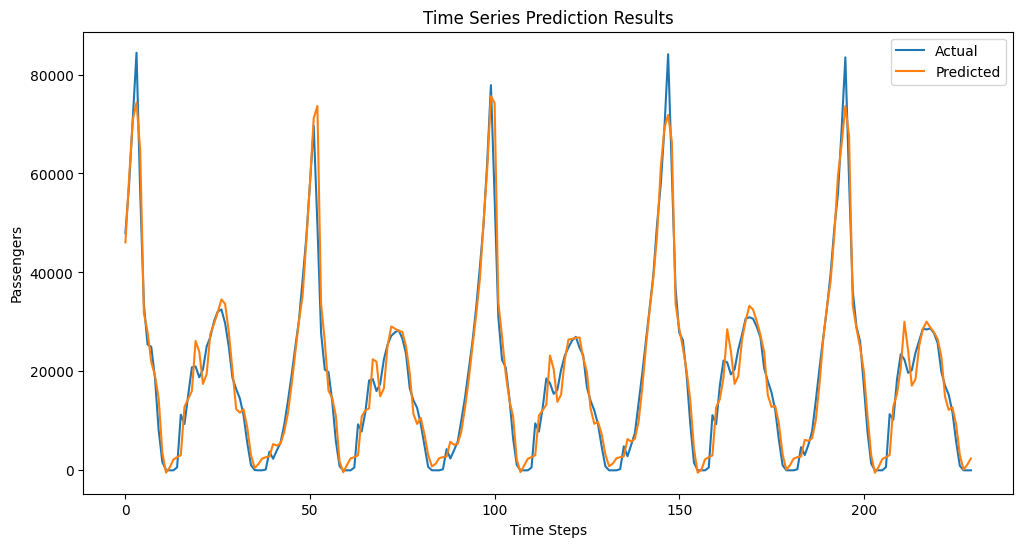

In [37]:
# 예시: 특정 역만 추출
station = data['지하철역'].unique()[0]  # 첫 번째 역
df_station = data[data['지하철역'] == station].sort_values('사용월')

# 시간대별 승차인원만 추출
boarding_cols = [col for col in data.columns if '승차인원' in col]
series = df_station[boarding_cols].values.flatten()  # 1D 시계열

# 스케일링
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

# 시퀀스 생성
def create_sequences(series, window=6):
    X, y = [], []
    for i in range(len(series)-window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequences(series_scaled, window=window_size)

# train/test 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM 입력 형태로 변환
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# 5. 모델 아키텍처
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

# 6. 학습률 스케줄링
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# 7. 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# 8. 조기 종료 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

# 9. 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 10. 성능 평가
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# 11. 예측 결과 시각화
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Time Series Prediction Results')
plt.xlabel('Time Steps')
plt.ylabel('Passengers')
plt.legend()
plt.show()

Epoch 1/100


c:\Users\kkh02\llll\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0766 - mae: 0.1900 - val_loss: 0.0262 - val_mae: 0.1289
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267 - mae: 0.1255 - val_loss: 0.0154 - val_mae: 0.0956
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - mae: 0.0841 - val_loss: 0.0082 - val_mae: 0.0579
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113 - mae: 0.0679 - val_loss: 0.0071 - val_mae: 0.0559
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0616 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0561 - val_loss: 0.0051 - val_mae: 0.0449
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mae: 0.0516 - val_loss: 0.0047 - val_mae: 0.0420
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0525 - val_loss: 0.0051 - val_mae: 0.0482
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 

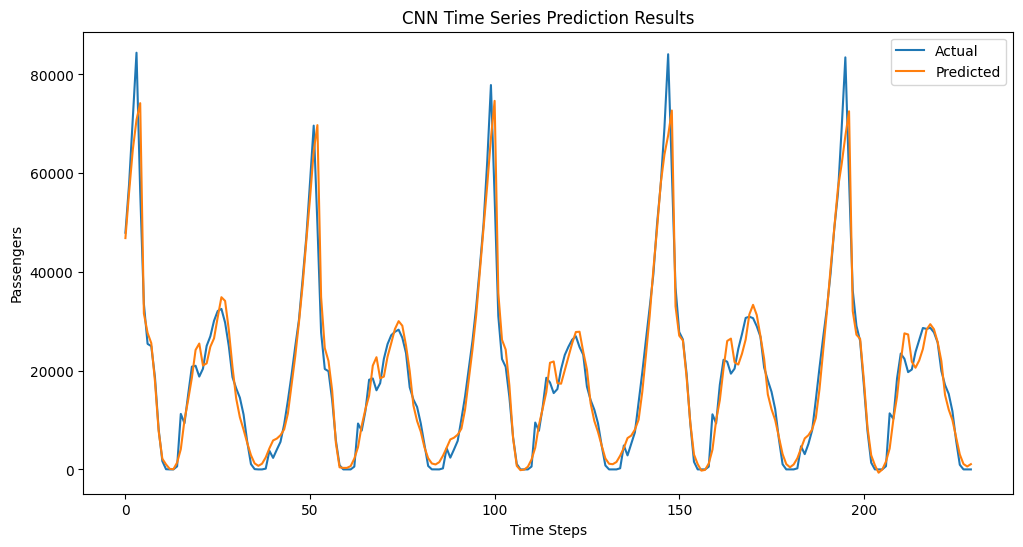

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 1. 특정 역만 추출 (예: 첫 번째 역)
station = data['지하철역'].unique()[0]
df_station = data[data['지하철역'] == station].sort_values('사용월')

# 2. 시간대별 승차인원만 추출하여 1D 시계열로 변환
boarding_cols = [col for col in data.columns if '승차인원' in col]
series = df_station[boarding_cols].values.flatten()

# 3. 스케일링
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

# 4. 시퀀스 생성 함수
def create_sequences(series, window=6):
    X, y = [], []
    for i in range(len(series)-window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 6
X, y = create_sequences(series_scaled, window=window_size)

# 5. 학습/테스트 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. CNN 입력 형태 변환
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# 7. CNN 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

# 8. 학습률 스케줄링
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# 9. 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mse',
    metrics=['mae']
)

# 10. 조기 종료 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

# 11. 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 12. 성능 평가
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

# 13. 예측 및 시각화
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Time Series Prediction Results')
plt.xlabel('Time Steps')
plt.ylabel('Passengers')
plt.legend()
plt.show()

LinearRegression: MSE=0.0034, MAE=0.0363, R2=0.9133
DecisionTree: MSE=0.0012, MAE=0.0140, R2=0.9686
RandomForest: MSE=0.0018, MAE=0.0145, R2=0.9549
GradientBoosting: MSE=0.0014, MAE=0.0161, R2=0.9642
SVR: MSE=0.0048, MAE=0.0571, R2=0.8774


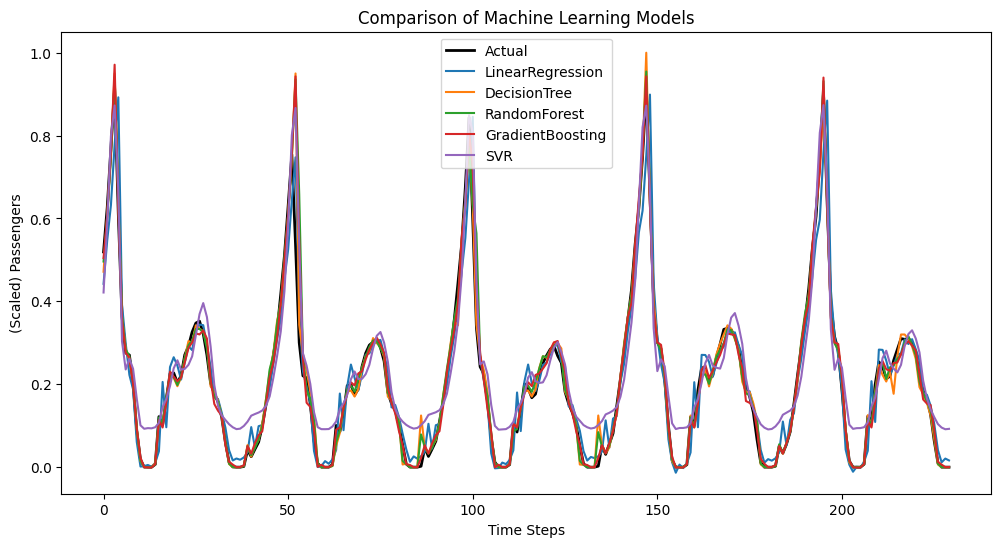

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 데이터 분할 (시계열 특성 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. 머신러닝 모델 리스트
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

# 3. 성능 비교
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

# 4. 실제값 vs 예측값 시각화(예: RandomForest)
import matplotlib.pyplot as plt
best_model = models['RandomForest']
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual', linewidth=2, color='black')

# 각 모델의 예측값
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.plot(y_pred, label=name)

plt.title('Comparison of Machine Learning Models')
plt.xlabel('Time Steps')
plt.ylabel('(Scaled) Passengers')
plt.legend()  # 각 선의 label을 자동으로 표시
plt.show()


In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import fisher_exact

# 데이터 복사
analysis_data = data.copy()

# 1. 시간대별 승차인원 컬럼 추출
boarding_cols = [col for col in analysis_data.columns if '승차인원' in col]

# 2. 각 역-월별 최대 승차인원 시간대 찾기
analysis_data['peak_boarding_col'] = analysis_data[boarding_cols].idxmax(axis=1)

# 3. 역-월별 정렬
analysis_data = analysis_data.sort_values(['지하철역', '사용월'])

# 4. 다음 달 피크 시간대 생성
analysis_data['next_month_peak'] = analysis_data.groupby('지하철역')['peak_boarding_col'].shift(-1)

# 5. 행동변화 변수 생성 (다음 달 피크 변경 여부)
analysis_data['behavior_change'] = (
    analysis_data['next_month_peak'] != analysis_data['peak_boarding_col']
).astype(int)

# 6. 마지막 달 데이터 제거 (다음 달 정보 없음)
analysis_data = analysis_data[analysis_data['next_month_peak'].notnull()]

# 7. 시간대별 혼잡시간대 변수 생성
for col in boarding_cols:
    analysis_data[f'congestion_{col}'] = (analysis_data['peak_boarding_col'] == col).astype(int)

# 8. 시간대별 오즈비 분석
results = []

for time_slot in boarding_cols:
    # 교차표 생성
    contingency_table = pd.crosstab(
        analysis_data[f'congestion_{time_slot}'], 
        analysis_data['behavior_change']
    )
    
    # 2x2 테이블 검증
    if contingency_table.shape != (2,2):
        print(f"Skipping {time_slot}: Invalid contingency table shape")
        continue
    # 피셔의 정확검정
    oddsratio, pvalue = fisher_exact(contingency_table)
    
    # 신뢰구간 계산
    res = sm.stats.Table2x2(contingency_table)
    ci_lower, ci_upper = res.oddsratio_confint()
    ci_lower, ci_upper = res.oddsratio_confint()
    
    results.append({
        'Time Slot': time_slot,
        'OR': round(oddsratio, 2),
        '95% CI Lower': round(ci_lower, 2),
        '95% CI Upper': round(ci_upper, 2),
        'p-value': round(pvalue, 4)
    })

# 9. 결과 정리
result_df = pd.DataFrame(results)
print(result_df)


Skipping 04시-05시 승차인원: Invalid contingency table shape
Skipping 23시-24시 승차인원: Invalid contingency table shape
Skipping 00시-01시 승차인원: Invalid contingency table shape
Skipping 01시-02시 승차인원: Invalid contingency table shape
Skipping 02시-03시 승차인원: Invalid contingency table shape
Skipping 03시-04시 승차인원: Invalid contingency table shape
       Time Slot     OR  95% CI Lower  95% CI Upper  p-value
0   05시-06시 승차인원    inf          0.73        360.96   0.0390
1   06시-07시 승차인원  32.61          4.08        260.86   0.0000
2   07시-08시 승차인원   0.45          0.40          0.50   0.0000
3   08시-09시 승차인원   0.84          0.77          0.92   0.0002
4   09시-10시 승차인원   7.44          3.56         15.54   0.0000
5   10시-11시 승차인원   8.19          3.97         16.90   0.0000
6   11시-12시 승차인원   4.34          2.74          6.85   0.0000
7   12시-13시 승차인원    inf          6.30       1790.30   0.0000
8   13시-14시 승차인원   7.72          3.44         17.34   0.0000
9   14시-15시 승차인원   6.39          4.06         10.05   0.0000

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import fisher_exact

# 데이터 복사
analysis_data = data.copy()

# 1. 시간대별 승차인원 컬럼 추출
boarding_cols = [col for col in analysis_data.columns if '승차인원' in col]

# 2. 각 역-월별 상위 2개 피크 시간대 찾기
def get_top2_cols(row):
    # Ensure values are numeric for nlargest
    numeric_vals = pd.to_numeric(row[boarding_cols], errors='coerce')
    return numeric_vals.nlargest(2).index.tolist()

analysis_data[['peak1_boarding_col', 'peak2_boarding_col']] = analysis_data.apply(
    lambda row: pd.Series(get_top2_cols(row)), axis=1
)

# 3. 역-월별 정렬
analysis_data = analysis_data.sort_values(['지하철역', '사용월'])

# 4. 다음 달 피크 시간대 생성 (각각)
analysis_data['next_month_peak1'] = analysis_data.groupby('지하철역')['peak1_boarding_col'].shift(-1)
analysis_data['next_month_peak2'] = analysis_data.groupby('지하철역')['peak2_boarding_col'].shift(-1)

# 5. 행동변화 변수 생성 (다음 달 피크1, 피크2 변경 여부)
analysis_data['behavior_change_peak1'] = (analysis_data['next_month_peak1'] != analysis_data['peak1_boarding_col']).astype(int)
analysis_data['behavior_change_peak2'] = (analysis_data['next_month_peak2'] != analysis_data['peak2_boarding_col']).astype(int)

# 6. 마지막 달 데이터 제거 (다음 달 정보 없음)
analysis_data = analysis_data[analysis_data['next_month_peak1'].notnull()]

# 7. 시간대별 혼잡시간대 변수 생성 (피크1, 피크2)
for col in boarding_cols:
    analysis_data[f'congestion1_{col}'] = (analysis_data['peak1_boarding_col'] == col).astype(int)
    analysis_data[f'congestion2_{col}'] = (analysis_data['peak2_boarding_col'] == col).astype(int)

# 8. 시간대별 오즈비 분석 (피크1, 피크2 각각)
results = []
for time_slot in boarding_cols:
    for peak_num in [1, 2]:
        congestion_col = f'congestion{peak_num}_{time_slot}'
        behavior_col = f'behavior_change_peak{peak_num}'
        contingency_table = pd.crosstab(
            analysis_data[congestion_col],
            analysis_data[behavior_col]
        )
        if contingency_table.shape != (2,2):
            print(f"Skipping {congestion_col}: Invalid contingency table shape")
            continue
        oddsratio, pvalue = fisher_exact(contingency_table)
        res = sm.stats.Table2x2(contingency_table)
        ci_lower, ci_upper = res.oddsratio_confint()
        results.append({
            'Peak': peak_num,
            'Time Slot': time_slot,
            'OR': round(oddsratio, 2),
            '95% CI Lower': round(ci_lower, 2),
            '95% CI Upper': round(ci_upper, 2),
            'p-value': round(pvalue, 4)
        })

# 9. 결과 정리
result_df = pd.DataFrame(results)
print(result_df)

Skipping congestion1_04시-05시 승차인원: Invalid contingency table shape
Skipping congestion1_23시-24시 승차인원: Invalid contingency table shape
Skipping congestion1_00시-01시 승차인원: Invalid contingency table shape
Skipping congestion2_00시-01시 승차인원: Invalid contingency table shape
Skipping congestion1_01시-02시 승차인원: Invalid contingency table shape
Skipping congestion2_01시-02시 승차인원: Invalid contingency table shape
Skipping congestion1_02시-03시 승차인원: Invalid contingency table shape
Skipping congestion2_02시-03시 승차인원: Invalid contingency table shape
Skipping congestion1_03시-04시 승차인원: Invalid contingency table shape
Skipping congestion2_03시-04시 승차인원: Invalid contingency table shape
    Peak     Time Slot     OR  95% CI Lower  95% CI Upper  p-value
0      2  04시-05시 승차인원   6.15          2.83         13.37   0.0000
1      1  05시-06시 승차인원    inf          0.73        360.96   0.0390
2      2  05시-06시 승차인원    inf          0.75        300.29   0.0232
3      1  06시-07시 승차인원  32.61          4.08        260.86   0.